First we **import** the needed libraries

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

Then we can load the `VGG17 pre-trained model` and add our **custom layers** on top

In [23]:
# Load VGG16 pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in VGG16 to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the VGG16 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # We can increase the number of units for increased model accuracy (makes training more hardware-intensive)
x = Dense(2711, activation='softmax')(x)

# Initialize the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:loc

Now we need to **load** our dataset. In this case `Labeled Faces in the Wild (LFW)` with deep funneled images is implemented. In order to use the date we need to **segregate** the data into data for training and data for validation. When it comes to the dataset `deep funneled` images are chosen since the model is trained locally and there are hardware limitations which will be easier to adhere to using pre-optimized images. These limitations are also why only about half of the images available in `LFW` were used for this model

In [29]:
import os
import shutil
import random

# Paths
original_dir = r'D:\Coding Projects\CNN (face recog)\lfw-deepfunneled'  # The original dataset path
train_dir = r'D:\Coding Projects\CNN (face recog)\lfw-deepfunneled\train'  # Path to save the training images
val_dir = r'D:\Coding Projects\CNN (face recog)\lfw-deepfunneled\val'  # Path to save the validation images

# Create the train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Iterate over each person's folder in the original directory
for person in os.listdir(original_dir):
    person_dir = os.path.join(original_dir, person)

    # Check if it's a directory (skip if not a person folder)
    if os.path.isdir(person_dir):
        # Create subdirectories for training and validation for this person
        person_train_dir = os.path.join(train_dir, person)
        person_val_dir = os.path.join(val_dir, person)
        
        # Create the person's subdirectories inside train and val
        os.makedirs(person_train_dir, exist_ok=True)
        os.makedirs(person_val_dir, exist_ok=True)
        
        # Get all image files in the person's folder
        images = [img for img in os.listdir(person_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Shuffle images for randomness
        random.shuffle(images)

        # Set the proportion for validation (in this case 80% train and 20% validation)
        num_images = len(images)
        num_val_images = int(0.2 * num_images)  # 20% for validation
        num_train_images = num_images - num_val_images  # 80% for training

        # Split into training and validation sets
        train_images = images[:num_train_images]
        val_images = images[num_train_images:]

        # Move the training images to the train folder
        for img in train_images:
            src_path = os.path.join(person_dir, img)
            dest_path = os.path.join(person_train_dir, img)
            shutil.move(src_path, dest_path)

        # Move the validation images to the validation folder
        for img in val_images:
            src_path = os.path.join(person_dir, img)
            dest_path = os.path.join(person_val_dir, img)
            shutil.move(src_path, dest_path)

        print(f"Processed {person} - {num_train_images} training images, {num_val_images} validation images.")
        print("Dataset split into training and validation sets successfully.")

Processed Aaron_Eckhart - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Aaron_Guiel - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Aaron_Patterson - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Aaron_Peirsol - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Aaron_Pena - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Aaron_Sorkin - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Aaron_Tippin - 0 training images, 0 validation images.
Dataset split into training and validation sets successfully.
Processed Abbas_Kiarostami - 0 training images, 0 validation images.
Dataset split into training and validati

**Prepare** the newly separated data

In [31]:
# Set up the ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply only rescaling to the validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = r'D:\Coding Projects\CNN (face recog)\lfw-deepfunneled\train'
val_dir = r'D:\Coding Projects\CNN (face recog)\lfw-deepfunneled\val'

# Create generators for loading and augmenting the images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Since we are doing multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6068 images belonging to 2711 classes.
Found 592 images belonging to 2711 classes.


The next step is to start **training** the model

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,  # Number of epochs can be increased for better model performance (number is low because of local hardware limitations)
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

C:\Users\Val\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/2
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Ex

C:\Users\Val\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_5376 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_5376 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_5376 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CP

Optionally, we can **unfreeze** the last layers of the base `general-purpose image recognition model` and recompile with a lower learning rate to **fine-tune** our result

In [ ]:
# Unfreeze the last few layers of the base model (VGG16)
for layer in base_model.layers[-4:]:  # Fine-tune the last 4 layers
    layer.trainable = True

# Recompile the model with a lower learning rate to fine-tune the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model with fine-tuning
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,  # Fine-tune for a few more epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Now we will **evaluate** our resulting model performance

In [41]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_11409 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:loc

Finally, we can display the **performance data**

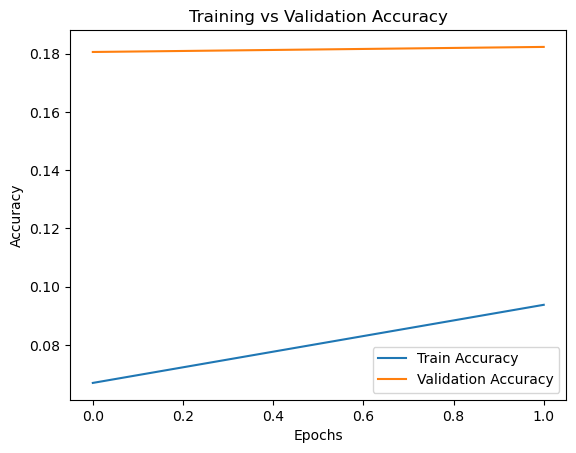

In [43]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that our model **validation accuracy** performance is **17%**, which is not good per-say, but considering that we have 2711 classes our model performs about 500 times better than random chance *(1/2711)*, which should serve as proof of concept and indicate that our model will perform significantly better, when trained in an environment with more effective hardware, allowing for increased training parameters and more iterations.